# Refinement plots

In [1]:
import os

from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter
from denovo_utils.io.read import load_psmlist

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from denovo_utils.analysis.metrics import load_seq_score_dicts
from denovo_utils.analysis.metrics import get_match_score_table, get_prc_curve

from psm_utils import Peptidoform
from tqdm import tqdm
from peak_pack.utils import calculate_ppm

from denovo_utils.analysis.metrics import (
    get_refinement_error_tables,
    plot_refinement_error_table,
    plot_precision_recall_refinement
)

2025-04-16 14:49:53.489258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-16 14:49:53.519066: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-16 14:49:53.526260: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Modification already exists in ModificationsDB. Skipping.


In [2]:
from denovo_utils.parsers.io.fasta import FastaHandler

fh = FastaHandler()
fh.read(path_fasta='/public/compomics3/Sam/config_files/fasta_databases/uniprot/UP000000625_UP000002311_UP000005640.fasta')

# 1. Load the data in Run objects

## 1.1 Load de novo results

In [12]:
# root_results_dn = '/public/compomics3/Sam/PXD028735/QExactive/denovo_output'
# root_mgf = '/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted'
# root_results_db = '/public/compomics3/Sam/PXD028735/QExactive/search_results/identification'

root_rescoring = '/public/compomics3/Sam/PXD028735/QExactive/rescoring'

run_names = [
    'LFQ_Orbitrap_DDA_Ecoli_01',
    'LFQ_Orbitrap_DDA_Human_01',
    'LFQ_Orbitrap_DDA_QC_01',
    'LFQ_Orbitrap_DDA_Yeast_01'
]

engine_names = [
    'adanovo',
    'pihelixnovo',
    'piprimenovo',
    'casanovo',
    'instanovo',
    'contranovo',
    'novob',
    'pepnet',
]

refinement_names = [
    'spectralis',
    'instanovoplus'
]

runs = {}
for run_name in run_names:
    print(f"Run: {run_name}")
    run = Run(run_name)

    gt_path = os.path.join(root_rescoring, run_name, 'psmlist', 'ground_truth.parquet')
    psmlist_gt = load_psmlist(gt_path)
    run.load_data(
        psmlist=psmlist_gt.get_rank1_psms(),
        score_names=['score_ms2rescore'],
        is_ground_truth=True
    )

    for engine_name in engine_names:
        print(f'loading {engine_name}')

        denovo_path = os.path.join(root_rescoring, run_name, 'psmlist', f'{engine_name}.parquet')
        psmlist_denovo = load_psmlist(denovo_path)
        run.load_data(
            psmlist=psmlist_denovo,
            score_names=['score_ms2rescore'],
            is_ground_truth=False
        )
    
        # load refinement
        for refinement_name in refinement_names:
            refinement_path = os.path.join(root_rescoring, run_name, 'psmlist', f'{engine_name}.{refinement_name}.parquet')
            if os.path.exists(refinement_path):
                print(f'    loading {refinement_name}')
                psmlist_refinement = load_psmlist(refinement_path)
                run.load_refinement(psmlist_refinement)

    runs[run_name] = run

Run: LFQ_Orbitrap_DDA_Ecoli_01


Loading results from ground_truth.parquet: 100%|██████████| 24285/24285 [00:02<00:00, 8491.27it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 24285/24285 [00:01<00:00, 21317.11it/s]


loading adanovo


Loading results from adanovo.parquet: 100%|██████████| 61843/61843 [00:09<00:00, 6483.14it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 61843/61843 [00:00<00:00, 122573.74it/s]


loading pihelixnovo


Loading results from pihelixnovo.parquet: 100%|██████████| 61955/61955 [00:10<00:00, 6064.35it/s] 
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 61955/61955 [00:00<00:00, 96630.98it/s] 


loading piprimenovo


Loading results from piprimenovo.parquet: 100%|██████████| 58682/58682 [00:07<00:00, 7627.04it/s] 
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 58682/58682 [00:00<00:00, 119805.64it/s]


loading casanovo


Loading results from casanovo.parquet: 100%|██████████| 61876/61876 [00:07<00:00, 7774.95it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 61876/61876 [00:00<00:00, 86920.11it/s] 


    loading spectralis


Loading results from casanovo.spectralis.parquet: 100%|██████████| 61876/61876 [00:11<00:00, 5565.72it/s]


    loading instanovoplus


Loading results from casanovo.instanovoplus.parquet: 100%|██████████| 61866/61866 [00:05<00:00, 10781.66it/s]


loading instanovo


Loading results from instanovo.parquet: 100%|██████████| 61562/61562 [00:05<00:00, 11023.15it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 61562/61562 [00:00<00:00, 125234.56it/s]


    loading spectralis


Loading results from instanovo.spectralis.parquet: 100%|██████████| 61562/61562 [00:07<00:00, 8685.88it/s]


    loading instanovoplus


Loading results from instanovo.instanovoplus.parquet: 100%|██████████| 61557/61557 [00:10<00:00, 5622.56it/s] 


loading contranovo


Loading results from contranovo.parquet: 100%|██████████| 30999/30999 [00:03<00:00, 8471.78it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 30999/30999 [00:00<00:00, 113056.27it/s]


    loading spectralis


Loading results from contranovo.spectralis.parquet: 100%|██████████| 31017/31017 [00:08<00:00, 3482.00it/s]


    loading instanovoplus


Loading results from contranovo.instanovoplus.parquet: 100%|██████████| 31015/31015 [00:02<00:00, 11067.65it/s]


loading novob


Loading results from novob.parquet: 100%|██████████| 61479/61479 [00:05<00:00, 10586.30it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 61479/61479 [00:00<00:00, 122549.36it/s]


    loading spectralis


Loading results from novob.spectralis.parquet: 100%|██████████| 61479/61479 [00:06<00:00, 9329.72it/s]


    loading instanovoplus


Loading results from novob.instanovoplus.parquet: 100%|██████████| 61476/61476 [00:11<00:00, 5513.06it/s] 


loading pepnet


Loading results from pepnet.parquet: 100%|██████████| 62560/62560 [00:07<00:00, 8831.15it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Ecoli_01): 100%|██████████| 62560/62560 [00:00<00:00, 127746.50it/s]


    loading spectralis


Loading results from pepnet.spectralis.parquet: 100%|██████████| 62559/62559 [00:06<00:00, 9057.95it/s] 


    loading instanovoplus


Loading results from pepnet.instanovoplus.parquet: 100%|██████████| 62557/62557 [00:05<00:00, 10949.42it/s]


Run: LFQ_Orbitrap_DDA_Human_01


Loading results from ground_truth.parquet: 100%|██████████| 90817/90817 [00:10<00:00, 8706.27it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 90817/90817 [00:01<00:00, 46911.83it/s]


loading adanovo


Loading results from adanovo.parquet: 100%|██████████| 115178/115178 [00:14<00:00, 7860.27it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 115178/115178 [00:14<00:00, 7987.60it/s] 


loading pihelixnovo


Loading results from pihelixnovo.parquet: 100%|██████████| 115417/115417 [00:26<00:00, 4384.31it/s] 
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 115417/115417 [00:02<00:00, 50146.00it/s]


loading piprimenovo


Loading results from piprimenovo.parquet: 100%|██████████| 111287/111287 [00:29<00:00, 3717.95it/s] 
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 111287/111287 [00:01<00:00, 59440.91it/s]


loading casanovo


Loading results from casanovo.parquet: 100%|██████████| 115362/115362 [00:15<00:00, 7557.15it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 115362/115362 [00:18<00:00, 6179.28it/s] 


    loading spectralis


Loading results from casanovo.spectralis.parquet: 100%|██████████| 115362/115362 [00:18<00:00, 6199.69it/s]


    loading instanovoplus


Loading results from casanovo.instanovoplus.parquet: 100%|██████████| 115340/115340 [00:10<00:00, 10708.34it/s]


loading instanovo


Loading results from instanovo.parquet: 100%|██████████| 114725/114725 [00:11<00:00, 9726.32it/s] 
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 114725/114725 [00:24<00:00, 4663.69it/s]


    loading spectralis


Loading results from instanovo.spectralis.parquet: 100%|██████████| 114725/114725 [00:12<00:00, 9148.05it/s]


    loading instanovoplus


Loading results from instanovo.instanovoplus.parquet: 100%|██████████| 114712/114712 [00:37<00:00, 3030.13it/s] 


loading contranovo


Loading results from contranovo.parquet: 100%|██████████| 57640/57640 [00:06<00:00, 8263.28it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 57640/57640 [00:01<00:00, 30640.82it/s]


    loading spectralis


Loading results from contranovo.spectralis.parquet: 100%|██████████| 57677/57677 [00:08<00:00, 6994.87it/s]


    loading instanovoplus


Loading results from contranovo.instanovoplus.parquet: 100%|██████████| 57669/57669 [00:07<00:00, 7296.05it/s]


loading novob


Loading results from novob.parquet: 100%|██████████| 114064/114064 [00:12<00:00, 9154.46it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 114064/114064 [00:03<00:00, 32040.51it/s]


    loading spectralis


Loading results from novob.spectralis.parquet: 100%|██████████| 114063/114063 [00:12<00:00, 8818.33it/s]


    loading instanovoplus


Loading results from novob.instanovoplus.parquet: 100%|██████████| 114060/114060 [00:10<00:00, 10500.33it/s]


loading pepnet


Loading results from pepnet.parquet: 100%|██████████| 118245/118245 [00:13<00:00, 8599.32it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Human_01): 100%|██████████| 118245/118245 [00:01<00:00, 59632.20it/s]


    loading spectralis


Loading results from pepnet.spectralis.parquet: 100%|██████████| 118245/118245 [00:12<00:00, 9432.95it/s]


    loading instanovoplus


Loading results from pepnet.instanovoplus.parquet: 100%|██████████| 118226/118226 [00:11<00:00, 10584.50it/s]


Run: LFQ_Orbitrap_DDA_QC_01


Loading results from ground_truth.parquet: 100%|██████████| 83941/83941 [00:39<00:00, 2106.63it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 83941/83941 [00:03<00:00, 23547.21it/s]


loading adanovo


Loading results from adanovo.parquet: 100%|██████████| 107088/107088 [00:14<00:00, 7370.29it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 107088/107088 [00:02<00:00, 53487.09it/s]


loading pihelixnovo


Loading results from pihelixnovo.parquet: 100%|██████████| 107182/107182 [00:13<00:00, 8171.04it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 107182/107182 [00:02<00:00, 51028.03it/s]


loading piprimenovo


Loading results from piprimenovo.parquet: 100%|██████████| 103511/103511 [00:08<00:00, 11700.17it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 103511/103511 [00:01<00:00, 53267.23it/s]


loading casanovo


Loading results from casanovo.parquet: 100%|██████████| 107203/107203 [00:13<00:00, 7785.33it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 107203/107203 [00:01<00:00, 54474.88it/s]


    loading spectralis


Loading results from casanovo.spectralis.parquet: 100%|██████████| 107203/107203 [00:12<00:00, 8630.11it/s]


    loading instanovoplus


Loading results from casanovo.instanovoplus.parquet: 100%|██████████| 107192/107192 [00:10<00:00, 10601.78it/s]


loading instanovo


Loading results from instanovo.parquet: 100%|██████████| 106604/106604 [00:13<00:00, 7796.79it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 106604/106604 [00:01<00:00, 53941.98it/s]


    loading spectralis


Loading results from instanovo.spectralis.parquet: 100%|██████████| 106604/106604 [00:11<00:00, 9118.53it/s]


    loading instanovoplus


Loading results from instanovo.instanovoplus.parquet: 100%|██████████| 106590/106590 [00:52<00:00, 2043.58it/s]


loading contranovo


Loading results from contranovo.parquet: 100%|██████████| 53533/53533 [00:08<00:00, 6568.48it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 53533/53533 [00:01<00:00, 49451.23it/s]


    loading spectralis


Loading results from contranovo.spectralis.parquet: 100%|██████████| 53579/53579 [00:05<00:00, 9293.80it/s]


    loading instanovoplus


Loading results from contranovo.instanovoplus.parquet: 100%|██████████| 53570/53570 [00:04<00:00, 10983.37it/s]


loading novob


Loading results from novob.parquet: 100%|██████████| 106075/106075 [00:10<00:00, 10236.62it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 106075/106075 [00:02<00:00, 39324.23it/s]


    loading spectralis


Loading results from novob.spectralis.parquet: 100%|██████████| 106075/106075 [00:12<00:00, 8709.10it/s]


    loading instanovoplus


Loading results from novob.instanovoplus.parquet: 100%|██████████| 106070/106070 [00:10<00:00, 9845.60it/s]


loading pepnet


Loading results from pepnet.parquet: 100%|██████████| 109340/109340 [00:12<00:00, 8576.90it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 109340/109340 [00:01<00:00, 57261.60it/s]


    loading spectralis


Loading results from pepnet.spectralis.parquet: 100%|██████████| 109338/109338 [00:11<00:00, 9111.80it/s]


    loading instanovoplus


Loading results from pepnet.instanovoplus.parquet: 100%|██████████| 109326/109326 [00:11<00:00, 9661.78it/s] 


Run: LFQ_Orbitrap_DDA_Yeast_01


Loading results from ground_truth.parquet: 100%|██████████| 67111/67111 [00:08<00:00, 7851.69it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 67111/67111 [00:01<00:00, 55438.65it/s]


loading adanovo


Loading results from adanovo.parquet: 100%|██████████| 102427/102427 [00:13<00:00, 7632.41it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 102427/102427 [00:01<00:00, 66459.95it/s]


loading pihelixnovo


Loading results from pihelixnovo.parquet: 100%|██████████| 102483/102483 [00:08<00:00, 11598.01it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 102483/102483 [00:01<00:00, 72623.21it/s]


loading piprimenovo


Loading results from piprimenovo.parquet: 100%|██████████| 96975/96975 [00:08<00:00, 11533.78it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 96975/96975 [00:01<00:00, 77951.73it/s] 


loading casanovo


Loading results from casanovo.parquet: 100%|██████████| 102518/102518 [00:13<00:00, 7719.14it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 102518/102518 [00:47<00:00, 2179.61it/s] 


    loading spectralis


Loading results from casanovo.spectralis.parquet: 100%|██████████| 102518/102518 [00:13<00:00, 7761.21it/s]


    loading instanovoplus


Loading results from casanovo.instanovoplus.parquet: 100%|██████████| 102498/102498 [00:09<00:00, 10683.34it/s]


loading instanovo


Loading results from instanovo.parquet: 100%|██████████| 101883/101883 [00:09<00:00, 11264.09it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 101883/101883 [00:01<00:00, 73083.06it/s]


    loading spectralis


Loading results from instanovo.spectralis.parquet: 100%|██████████| 101883/101883 [00:11<00:00, 9250.83it/s]


    loading instanovoplus


Loading results from instanovo.instanovoplus.parquet: 100%|██████████| 101875/101875 [00:10<00:00, 10004.96it/s]


loading contranovo


Loading results from contranovo.parquet: 100%|██████████| 51215/51215 [00:09<00:00, 5433.52it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 51215/51215 [00:55<00:00, 922.37it/s]  


    loading spectralis


Loading results from contranovo.spectralis.parquet: 100%|██████████| 51246/51246 [00:05<00:00, 9527.37it/s] 


    loading instanovoplus


Loading results from contranovo.instanovoplus.parquet: 100%|██████████| 51239/51239 [00:05<00:00, 9999.52it/s] 


loading novob


Loading results from novob.parquet: 100%|██████████| 101183/101183 [00:09<00:00, 10578.10it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 101183/101183 [00:01<00:00, 77765.85it/s]


    loading spectralis


Loading results from novob.spectralis.parquet: 100%|██████████| 101183/101183 [00:11<00:00, 9163.16it/s]


    loading instanovoplus


Loading results from novob.instanovoplus.parquet: 100%|██████████| 101178/101178 [00:09<00:00, 10984.80it/s]


loading pepnet


Loading results from pepnet.parquet: 100%|██████████| 103785/103785 [00:12<00:00, 8536.05it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_Yeast_01): 100%|██████████| 103785/103785 [00:01<00:00, 72425.32it/s]


    loading spectralis


Loading results from pepnet.spectralis.parquet: 100%|██████████| 103785/103785 [01:06<00:00, 1562.13it/s]


    loading instanovoplus


Loading results from pepnet.instanovoplus.parquet: 100%|██████████| 103766/103766 [00:10<00:00, 10250.36it/s]


## Evaluate

In [13]:
for run in runs.values():
    for spectrum in tqdm(run.spectra.values()):
        psm_gt = spectrum.psm_gt
        psm_gt.scores.add_score(
            score=psm_gt.scores.get_score('sage'),
            metadata='score_ms2rescore',
            score_type='peptide'
        )

100%|██████████| 43131/43131 [00:00<00:00, 397134.13it/s]


In [14]:
# Perform error type analysis
for run in runs.values():
    for spectrum in tqdm(run.spectra.values()):
        spectrum.compare_gt(
            metadata_score="score_ms2rescore"
        )

100%|██████████| 43131/43131 [00:37<00:00, 1142.83it/s]


In [15]:
for run in runs.values():
    for spectrum in tqdm(run.spectra.values()):
        spectrum.compare_gt(
            metadata_score="score_ms2rescore",
            refinements=['Spectralis', 'InstaNovo+']
        )

100%|██████████| 43131/43131 [01:02<00:00, 688.49it/s]


In [16]:
def load_seq_score_dicts(
        run,
        denovo_name,
        total_predicted
):
    denovo_seqs = {
        denovo_name: {},
        "score_ms2rescore": {},
        "Spectralis": {}
    }

    for score_metadata in denovo_seqs.keys():
        t = get_match_score_table(
            run, 
            engine=denovo_name,
            score_metadata=score_metadata,
            eval_score_metadata='score_ms2rescore',
            return_table=True
        )       
        prc = get_prc_curve(t, total_predicted)

        denovo_seqs[score_metadata] = {
            'precision': prc.precision.to_numpy(),
            'recall': prc.recall.to_numpy(),
            'coverage': prc.coverage.to_numpy()
        }

    spectralis_seqs = {
        "Spectralis": [],
        "score_ms2rescore": []
    }

    for score_metadata in spectralis_seqs.keys():
        t = get_match_score_table(
            run,
            engine=denovo_name,
            score_metadata=score_metadata,
            refiner="Spectralis",
            eval_score_metadata='score_ms2rescore',
            return_table=True
        )
        
        prc = get_prc_curve(t, total_predicted)
        spectralis_seqs[score_metadata] = {
            'precision': prc.precision.to_numpy(),
            'recall': prc.recall.to_numpy(),
            'coverage': prc.coverage.to_numpy()
        }
    
    instanovo_seqs = {
        "InstaNovo+": [],
        "score_ms2rescore": []
    }

    for score_metadata in instanovo_seqs.keys():
        t = get_match_score_table(
            run,
            engine=denovo_name,
            score_metadata=score_metadata,
            eval_score_metadata='score_ms2rescore',
            refiner="InstaNovo+",
            return_table=True
        )
        prc = get_prc_curve(t, total_predicted)

        instanovo_seqs[score_metadata] = {
            'precision': prc.precision.to_numpy(),
            'recall': prc.recall.to_numpy(),
            'coverage': prc.coverage.to_numpy()
        }

    seq_score_dict = {
        "denovo_seqs": denovo_seqs,
        "spectralis_seqs": spectralis_seqs,
        "instanovo_seqs": instanovo_seqs
    }
    return seq_score_dict


def plot_precision_recall_refinement(
        denovo_seqs,
        spectralis_seqs,
        instanovo_seqs,
        denovo_name,
        ax,
        max_points_per_plot=1000
):

    # Sample color mappings
    denovo_color = "r"
    spectralis_color = "b"
    instanovo_color = "g"

    # Line style mappings
    score_type_styles = {
        denovo_name: "solid",
        "InstaNovo+": "solid",
        "Spectralis": "dashdot",
        "score_ms2rescore": "dotted"
    }

    # Create figure and axis

    print("denovo")
    # Loop over the denovo sequences
    for score_type, pr_dict in denovo_seqs.items():
        print("plotting", score_type)
        sns.lineplot(
            x=pr_dict["coverage"],
            y=pr_dict["precision"],
            label=score_type,   # Label for style legend
            linestyle=score_type_styles[score_type],  # Set line style
            color=denovo_color,  # Set color
            alpha=.5,
            ax=ax
        )

    print("spectralis")
    # Loop over the spectralis sequences
    for score_type, pr_dict in spectralis_seqs.items():
        print("plotting", score_type)
        sns.lineplot(
            x=pr_dict["coverage"],
            y=pr_dict["precision"],
            label=score_type,   # Label for style legend
            linestyle=score_type_styles[score_type],  # Set line style
            color=spectralis_color,  # Set color
            alpha=.5,
            ax=ax
        )

    print("instanovo+")
    # Loop over the instanovo sequences
    for score_type, pr_dict in instanovo_seqs.items():
        print("plotting", score_type)
        sns.lineplot(
            x=pr_dict["coverage"],
            y=pr_dict["precision"],
            label=score_type,   # Label for style legend
            linestyle=score_type_styles[score_type],  # Set line style
            color=instanovo_color,  # Set color
            alpha=.5,
            ax=ax
        )

    # Create separate legends
    # First, get handles and labels from the plot
    handles, labels = ax.get_legend_handles_labels()

    # Separate out color-based and style-based labels for different legends
    color_legend_labels = [denovo_name, 'Spectralis', 'InstaNovo']
    style_legend_labels = [denovo_name, 'InstaNovo+', 'Spectralis', 'score_ms2rescore']

    # Add legends outside the plot
    color_handles = [plt.Line2D([0], [0], color=c, lw=3) for c in [denovo_color, spectralis_color, instanovo_color]]
    style_handles = [plt.Line2D([0], [0], linestyle=score_type_styles[label], color='k', lw=1) for label in style_legend_labels]
    leg1 = ax.legend(color_handles, color_legend_labels, title="Sequence", loc='upper left', bbox_to_anchor=(1, 1))  # Outside top-right
    leg2 = ax.legend(style_handles, style_legend_labels, title="Score Type", loc='lower left', bbox_to_anchor=(1, 0))  # Outside bottom-right

    ax.add_artist(leg1)
    ax.add_artist(leg2)
    ax.legend(color_handles, color_legend_labels, title="Dataset", loc='upper left', bbox_to_anchor=(1, 1))  # Outside top-right

    # Adjust plot to make space for legends
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust space for legends outside the plot

    # Ensure both legends are shown
    plt.show()

In [ ]:
def in_fasta(sequence, fasta):
    for fasta_sequence in fasta['sequence']:
        if sequence in fasta_sequence:
            return True
    return False
    

fasta_sequences = fh.dataframe['sequence'].tolist()
def reannotate_error_type(run: Run, reannotation_labels):
    for spectrum in run.spectra.values():
        for psm in spectrum.psm_candidates:
            error_type = psm.evaluation['score_ms2rescore'].error_type
            if error_type in mapping.keys():

                if error_type != 'match':
                    if in_fasta(psm.peptidoform.stripped_sequence, fasta=fasta_sequences):
                        psm.evaluation['score_ms2rescore'].error_type = 'No match - In FASTA'

                    else:
                        psm.evaluation['score_ms2rescore'].error_type = 'No match - Not in FASTA'


mapping = {

}

runs['LFQ_Orbitrap_DDA_Ecoli_01'].spectra['controllerType=0 controllerNumber=1 scan=10014'].psm_candidates[0].evaluation['score_ms2rescore'].error_type

'Lower score'

/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464


Creating plots for 43077 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'contranovo']).
denovo
plotting casanovo
plotting score_ms2rescore
plotting Spectralis
spectralis
plotting Spectralis
plotting score_ms2rescore
instanovo+
plotting InstaNovo+
plotting score_ms2rescore


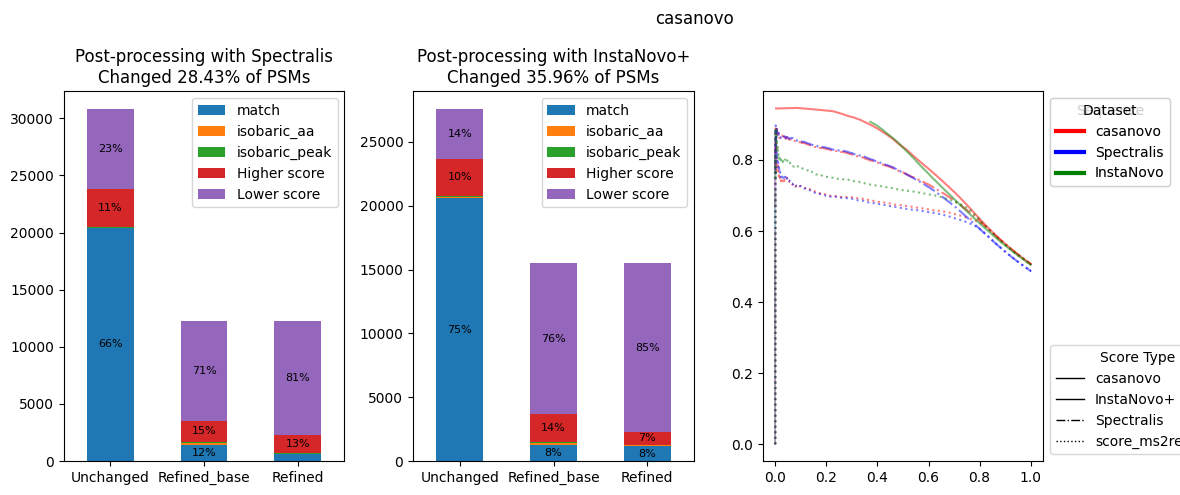

/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464


Creating plots for 42876 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'contranovo']).
denovo
plotting novob
plotting score_ms2rescore
plotting Spectralis
spectralis
plotting Spectralis
plotting score_ms2rescore
instanovo+
plotting InstaNovo+
plotting score_ms2rescore


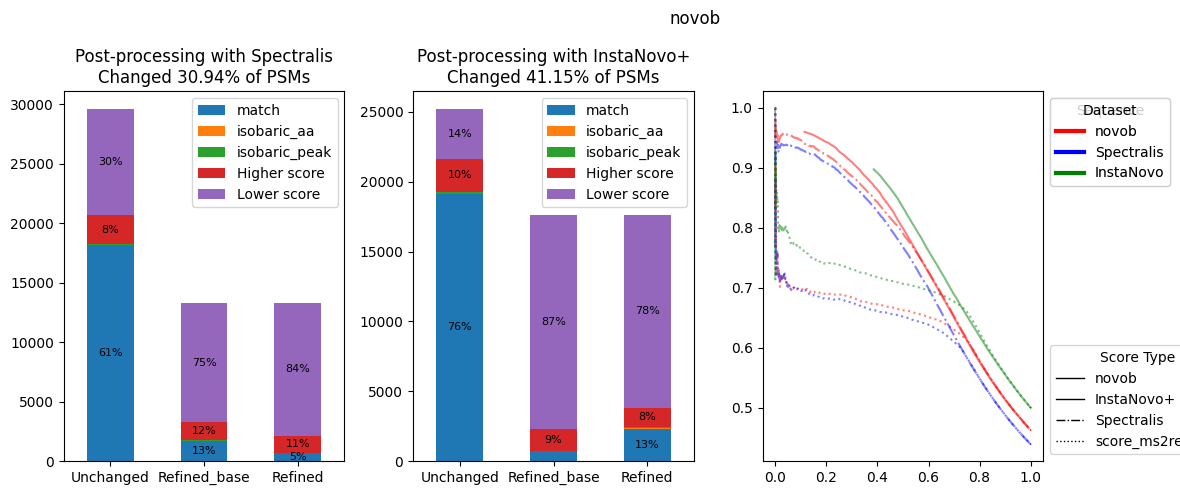

/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464


Creating plots for 43072 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'contranovo']).
denovo
plotting instanovo
plotting score_ms2rescore
plotting Spectralis
spectralis
plotting Spectralis
plotting score_ms2rescore
instanovo+
plotting InstaNovo+
plotting score_ms2rescore


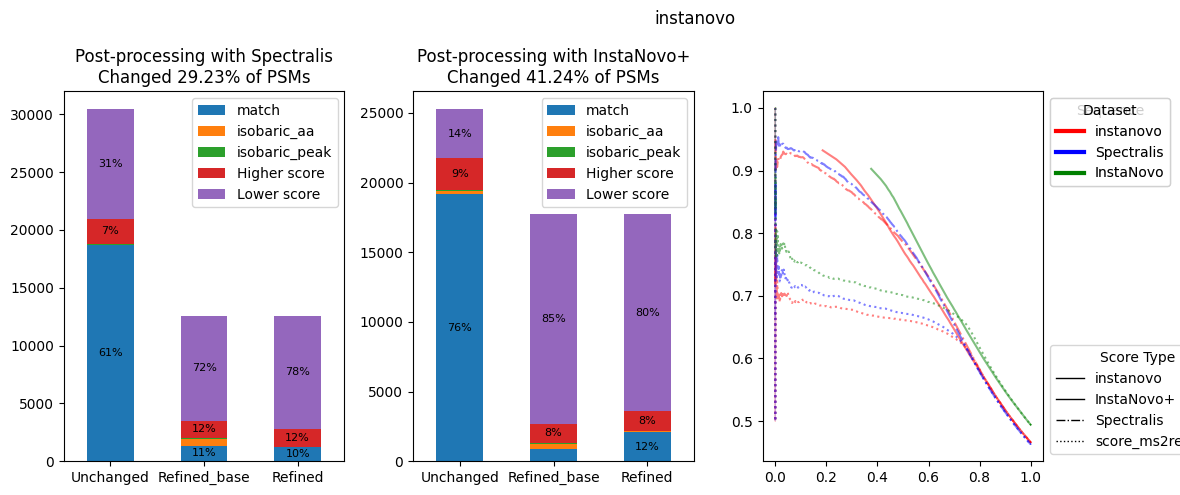

/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464


Creating plots for 43131 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'novob', 'pepnet', 'contranovo']).
denovo
plotting pepnet
plotting score_ms2rescore
plotting Spectralis
spectralis
plotting Spectralis
plotting score_ms2rescore
instanovo+
plotting InstaNovo+
plotting score_ms2rescore


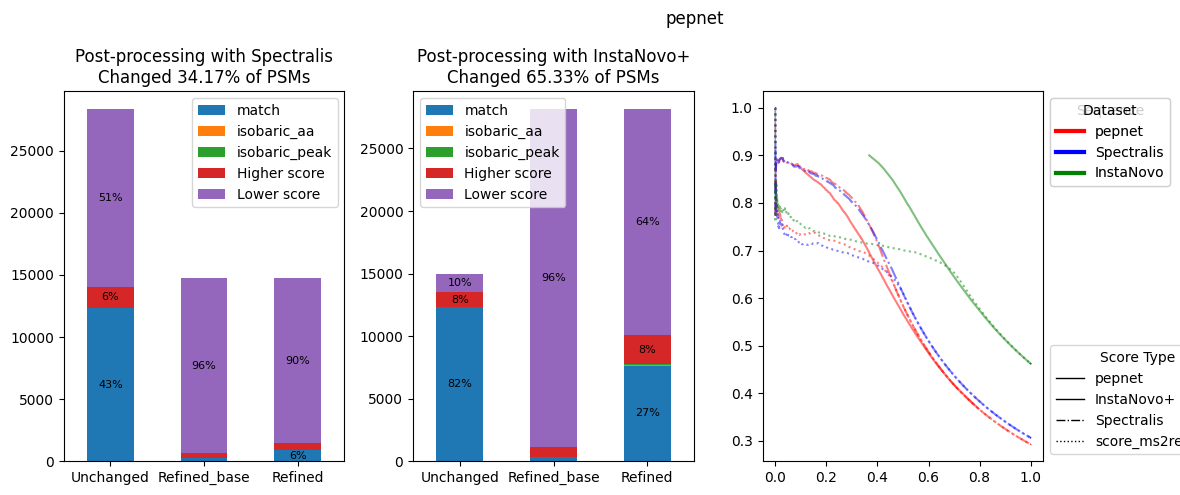

/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464: RuntimeWarning: invalid value encountered in scalar divide
  precision = c/ci
/home/sam/DeNovo/cloned_denovo_repo/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:464


Creating plots for 21612 spectra loaded from 8 engines (['AdaNovo', 'pi-HelixNovo', 'pi-PrimeNovo', 'casanovo', 'instanovo', 'contranovo', 'novob', 'pepnet']).
denovo
plotting contranovo
plotting score_ms2rescore
plotting Spectralis
spectralis
plotting Spectralis
plotting score_ms2rescore
instanovo+
plotting InstaNovo+
plotting score_ms2rescore


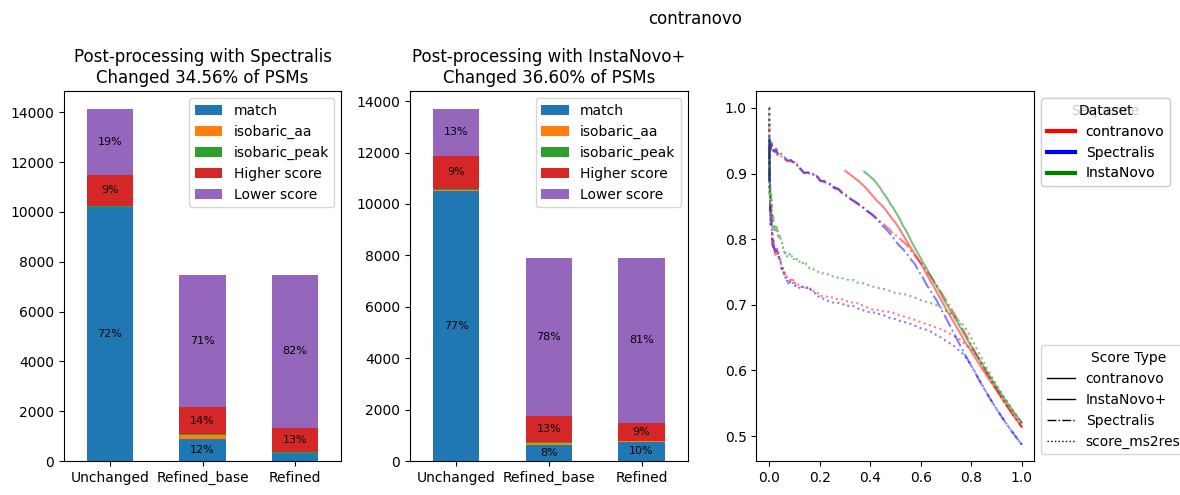

In [17]:
for engine in ['casanovo', 'novob', 'instanovo', 'pepnet', 'contranovo']:
    run_engine = run.get_common_spectra(engines=[engine])

    seq_score_dict = load_seq_score_dicts(
        run=run_engine,
        denovo_name=engine,
        total_predicted=len(run_engine.spectra)
    )

    fig, ax = plt.subplots(1,3, figsize=(14,5))
    fig.suptitle(engine)

    print("\nCreating plots for", run_engine)

    error_table = get_refinement_error_tables(run=run_engine, base_engine=engine, score_metadata='score_ms2rescore')
    plot_refinement_error_table(error_table, fig, ax)

    plot_precision_recall_refinement(
        denovo_seqs=seq_score_dict['denovo_seqs'],
        spectralis_seqs=seq_score_dict['spectralis_seqs'],
        instanovo_seqs=seq_score_dict['instanovo_seqs'],
        denovo_name=engine,
        ax=ax[2]
    )